In [15]:
from google.colab import drive
import os

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
!ls

5-celebrity-faces-dataset	  data
5-celebrity-faces-dataset.npz	  facenet.ipynb
5-celebrity-faces-embeddings.npz  facenet_keras.h5


In [17]:
%cd '/content/gdrive/My Drive/deep_learning/facenet_test'

/content/gdrive/My Drive/deep_learning/facenet_test


In [0]:
path = "/content/gdrive/My Drive/deep_learning/facenet_test"
os.chdir(path)

In [19]:

# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Identity:0' shape=(None, 128) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
!pip install mtcnn

In [21]:

# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)



0.1.0


In [23]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):  
  print(filename)
  check = True
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  image = image.convert('RGB')
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  if (len(results) >0):
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    
  else:
    face_array = []
    check = False
  return face_array, check


 
# load images and extract faces for all images in a directory
def load_faces(directory):
  faces = list()
  # enumerate files
  for filename in listdir(directory):
    # path
    path = directory + filename
    # get face
    face,check = extract_face(path)
    if (check == True):
      faces.append(face)
  return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)


5-celebrity-faces-dataset/train/elton_john/httpwwwjohnpauljonesarenacomeventimagesEltonCalendarVjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpwwwlautdeEltonJohneltonjohnjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpwwweonlinecomresizewwweonlinecomeolimagesEntireSitersxEltonJohnJRjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpsuploadwikimediaorgwikipediacommonsthumbEltonJohninsjpgpxEltonJohninsjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpsticketmnettmenusdamabbacdaebeafdbbCUSTOMjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpwwwdeadlinecomvimgnetwpcontentuploadseltonjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpssmediacacheakpinimgcomxfefdacfbfdeadajpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpssmediacacheakpinimgcomxfecfecaefaadfebejpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpmediapopsugarassetscomfilescbffewltonjpg.jpg
5-celebrity-faces-dataset/train/elton_john/httpssmediacacheakpinimgcomxfcfcbaeaeddabbjpg.jpg
5-ce

In [24]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (217, 160, 160, 3) (217,) (50, 160, 160, 3) (50,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(217, 128)
(50, 128)


In [25]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=217, test=50
Accuracy: train=100.000, test=100.000


Predicted: madonna (70.825)
Expected: madonna


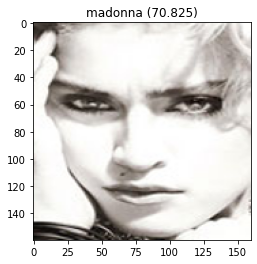

In [31]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()